In [ ]:
# Paper : "Denoising Diffusion Probabilistic Models" by Jonathan Ho et al. (2020)
# The code below was written with reference to the paper's official open source code.
# Github Repository : https://github.com/hojonathanho/diffusion

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 1. Model

In [ ]:
def swish(x):
    # Activation function used in DDPM
    return x * torch.sigmoid(x)

def get_timestep_embedding(t, channel):
    """
    DDPM recieves timestep t as input to estimate the noise value.
    This embedding fuction takes timestep t as input and returns embedding vector according to t.

    Parameters:
        t (torch.Tensor) : Timesteps of batch data
        channel (int) : Number of embedding channels

    Returns:
        torch.Tensor : Embedding vector
    """
    half = channel // 2
    device = t.device
    freqs = torch.exp(
        -torch.arange(half, dtype=torch.float32, device=device) * 2.0 * 3.1415 / float(half)
    )
    embedded = []
    for val in t.float():
        sin_embed = torch.sin(val * freqs)
        cos_embed = torch.cos(val * freqs)
        embedded.append(torch.cat([sin_embed, cos_embed], dim=0))
    embedded = torch.stack(embedded, dim=0)
    if channel % 2 == 1:
        embedded = F.pad(embedded, (0,1,0,0))
    return embedded  # (B, channel)

class GroupNorm32(nn.GroupNorm):
    def __init__(self, num_channels, num_groups=32, eps=1e-6):
        super().__init__(num_groups, num_channels, eps=eps)

def conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True, init_scale=1.0):
    conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=bias)
    with torch.no_grad():
        conv.weight.data *= init_scale
    return conv

def nin(in_ch, out_ch, init_scale=1.0):
    # 1x1 convolution
    layer = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)
    with torch.no_grad():
        layer.weight.data *= init_scale
    return layer

def linear(in_features, out_features, init_scale=1.0):
    fc = nn.Linear(in_features, out_features)
    with torch.no_grad():
        fc.weight.data *= init_scale
    return fc

class DownsampleBlock(nn.Module):
    # Block that doubles down on resolution. Use convolution block or average pooling block.
    def __init__(self, channels, with_conv=True):
        super().__init__()
        if with_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        return self.op(x)

class UpsampleBlock(nn.Module):
    # Block that doubles the resolution. Use interpolating block.
    def __init__(self, channels, with_conv=True):
        super().__init__()
        self.with_conv = with_conv
        if with_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode='nearest')
        if self.with_conv:
            x = self.conv(x)
        return x

class ResnetBlock(nn.Module):
    """
    Resnet block used in DDPM. Use group normalization. Timestep t is also received as input.

    Parameters:
        in_channels (int) : Number of input channels
        out_channels (int) : Number of Output channels
        temb_channels (int) : Number of time embedding channels
        dropout (float) : Dropout rate
        conv_shortcut (bool) : Whether to add convolution shortcut
    """
    def __init__(self, in_channels, out_channels=None,
                 temb_channels=512, dropout=0.0, conv_shortcut=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels if out_channels is not None else in_channels
        self.temb_channels = temb_channels
        self.dropout = dropout
        self.conv_shortcut = conv_shortcut

        self.norm1 = GroupNorm32(self.in_channels)
        self.conv1 = conv2d(self.in_channels, self.out_channels,
                            kernel_size=3, stride=1, padding=1, init_scale=1.0)
        self.temb_proj = linear(self.temb_channels, self.out_channels, init_scale=1.0)
        self.norm2 = GroupNorm32(self.out_channels)
        self.conv2 = conv2d(self.out_channels, self.out_channels,
                            kernel_size=3, stride=1, padding=1, init_scale=0.0)

        if self.in_channels != self.out_channels:
            if self.conv_shortcut:
                self.conv_shortcut = nn.Conv2d(self.in_channels, self.out_channels,
                                               kernel_size=3, stride=1, padding=1)
            else:
                self.conv_shortcut = nin(self.in_channels, self.out_channels)
        else:
            self.conv_shortcut = None

    def forward(self, x, temb):
        """
        Parameters:
            x (torch.Tensor) : Input data
            temb (torch.Tensor) : Embedding vector of timestep t

        Returns:
            torch.Tensor : Output data

        Example:
            >>> x = torch.randn(128,3,224,224)
            >>> temb = torch.randn(128,512)
            >>> block = ResnetBlock(in_channels=3,out_channels=32,temb_channels=512)
            >>> out = block(x,temb)
            >>> print(out.shape) # torch.Size([128,32,224,224])
        """
        h = self.norm1(x)
        h = swish(h)
        h = self.conv1(h)
        h_temb = swish(temb)
        h_temb = self.temb_proj(h_temb)  # (B, out_channels)
        h_temb = h_temb[:, :, None, None]  # (B, out_channels, 1, 1)
        h = h + h_temb
        h = self.norm2(h)
        h = swish(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.conv2(h)
        if self.conv_shortcut is not None:
            x = self.conv_shortcut(x)
        return x + h

class AttnBlock(nn.Module):
    """
    Attention block used in DDPM.

    Parameters:
        channels (int) : Number of input, output channels
    """
    def __init__(self, channels):
        super().__init__()
        self.norm = GroupNorm32(channels)
        self.q = nin(channels, channels)
        self.k = nin(channels, channels)
        self.v = nin(channels, channels)
        self.proj_out = nin(channels, channels, init_scale=0.0)

    def forward(self, x):
        """
        Parameters:
            x (torch.Tensor) : Input data

        Returns:
            torch.Tensor : Output data

        Example:
            >>> x = torch.randn(128,32,224,224)
            >>> block = AttnBlock(32)
            >>> out = block(x)
            >>> print(out.shape) # torch.Size([128,32,224,224])
        """
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).permute(0, 2, 3, 1)  # (B, H, W, C)
        k = self.k(h).permute(0, 2, 3, 1)
        v = self.v(h).permute(0, 2, 3, 1)
        w = torch.einsum('bhwc,bHWc->bhwHW', q, k) * (C ** -0.5)
        w = w.reshape(B, H, W, H * W)
        w = F.softmax(w, dim=-1)
        w = w.reshape(B, H, W, H, W)
        h_ = torch.einsum('bhwHW,bHWc->bhwc', w, v)
        h_ = self.proj_out(h_.permute(0, 3, 1, 2))
        return x + h_

class DDPMModel(nn.Module):
    """
    Final DDPMModel. Modified version of UNet.
    Attention block is applied to where it is set to applied.
    Given noised data x_t and timestep t, the model estimates the value of noise at timestep t.

    Parameters:
        in_channels (int) : Number of input channels
        out_channels (int) : Number of output channels
        ch (int) : Number of default channel
        ch_mult (tuple) : Coefficient multiblied by channels
        num_res_blocks (int) : Number of resnet blocks
        attn_resolutions (set) : Set of resolutions at which attention block applies
        dropout (float) : Dropout rate
        resamp_with_conv (bool) : Whether to use convolution whil down(up)sampling
        init_resolution (int) : Resolution of input images
    """
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        ch=64,
        ch_mult=(1, 2, 4),
        num_res_blocks=2,
        attn_resolutions={8},
        dropout=0.0,
        resamp_with_conv=True,
        init_resolution=32
    ):
        super().__init__()
        self.ch = ch
        self.ch_mult = ch_mult
        self.num_res_blocks = num_res_blocks
        self.attn_resolutions = attn_resolutions
        self.dropout = dropout
        self.num_levels = len(ch_mult)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.resamp_with_conv = resamp_with_conv
        self.init_resolution = init_resolution

        # Dimension of time embedding vector
        self.temb_ch = ch * 4

        # Timestep embedding layers
        self.temb_dense0 = linear(ch, self.temb_ch)
        self.temb_dense1 = linear(self.temb_ch, self.temb_ch)

        # Input conv
        self.conv_in = conv2d(in_channels, ch, kernel_size=3, stride=1, padding=1)

        # Downsample blocks
        # Each downsampling block(modulelist) is stored in down_blocks.
        # Each block is composed of resnetblocks and attention block(if needed).
        self.down_blocks = nn.ModuleList()
        curr_ch = ch
        curr_res = init_resolution
        for level in range(self.num_levels):
            level_blocks = nn.ModuleList()
            out_ch = ch * ch_mult[level]
            for i in range(num_res_blocks):
                level_blocks.append(ResnetBlock(curr_ch, out_ch, temb_channels=self.temb_ch, dropout=dropout))
                if curr_res in attn_resolutions:
                    level_blocks.append(AttnBlock(out_ch))
                curr_ch = out_ch
            self.down_blocks.append(level_blocks)
            if level != self.num_levels - 1:
                self.down_blocks.append(DownsampleBlock(curr_ch, with_conv=resamp_with_conv))
                curr_res //= 2

        # Middle blocks
        self.mid_block = nn.ModuleList([
            ResnetBlock(curr_ch, curr_ch, temb_channels=self.temb_ch, dropout=dropout),
            AttnBlock(curr_ch),
            ResnetBlock(curr_ch, curr_ch, temb_channels=self.temb_ch, dropout=dropout)
        ])

        # Upsample blocks
        # Symmetric structure with downsample blocks
        self.up_blocks = nn.ModuleList()
        for level in reversed(range(self.num_levels)):
            level_blocks = nn.ModuleList()
            out_ch = ch * ch_mult[level]
            level_blocks.append(ResnetBlock(curr_ch + out_ch, out_ch, temb_channels=self.temb_ch, dropout=dropout))
            if (init_resolution // (2 ** level)) in attn_resolutions:
                level_blocks.append(AttnBlock(out_ch))
            curr_ch = out_ch
            for i in range(num_res_blocks):
                level_blocks.append(ResnetBlock(curr_ch, curr_ch, temb_channels=self.temb_ch, dropout=dropout))
                if (init_resolution // (2 ** level)) in attn_resolutions:
                    level_blocks.append(AttnBlock(curr_ch))
            if level != 0:
                level_blocks.append(UpsampleBlock(curr_ch, with_conv=resamp_with_conv))
            self.up_blocks.append(level_blocks)

        # output conv
        self.norm_out = GroupNorm32(curr_ch)
        self.conv_out = conv2d(curr_ch, out_channels, kernel_size=3, stride=1, padding=1, init_scale=0.0)

    def forward(self, x, t):
        """
        Parameters:
            x (torch.Tensor) : Input data
            t (torch.Tensor) : Timesteps of batch data

        Returns:
            torch.Tensor : Output data

        Example:
            x = torch.randn(128,3,224,224)
            t = torch.randint(0,1000,(128,))
            model = DDPMModel(ch=128,attn_resolution={56})
            out = model(x,t)
            print(out.shape) # torch.Size([128,3,224,224])
        """
        # 1) Timestep embedding
        temb = get_timestep_embedding(t, self.ch)
        temb = self.temb_dense0(temb)
        temb = swish(temb)
        temb = self.temb_dense1(temb)

        # 2) Downsampling
        skips = []
        h = self.conv_in(x)
        down_iter = iter(self.down_blocks)
        for level in range(self.num_levels):
            blocks = next(down_iter)
            for layer in blocks:
                h = layer(h, temb) if isinstance(layer, ResnetBlock) else layer(h)
            skips.append(h)
            if level != self.num_levels - 1:
                downsample = next(down_iter)
                h = downsample(h)

        # 3) Middle
        for layer in self.mid_block:
            h = layer(h, temb) if isinstance(layer, ResnetBlock) else layer(h)

        # 4) Upsampling
        for level in range(self.num_levels):
            blocks = self.up_blocks[level]
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            h = blocks[0](h, temb)
            for layer in blocks[1:]:
                if isinstance(layer, ResnetBlock):
                    h = layer(h, temb)
                else:
                    h = layer(h)

        # 5) Output
        h = self.norm_out(h)
        h = swish(h)
        h = self.conv_out(h)
        return h


# 2. Train

In [ ]:
def get_beta_alpha(beta_schedule='linear', beta_start=0.0001, beta_end=0.002, num_timesteps=1000):
    """
    Generate values of beta, alpha and bar_alpha.

    Parameters:
        beta_schedule (str) : Method of generating beta. 'linear' or 'quad'
        beta_start (float) : Value of beta_0
        beta_end (float) : Value of beta_T
        num_timesteps (int) : Number of whole timesteps

    Returns:
        betas (torch.Tensor) : Value of betas
        alphas (torch.Tensor) : Value of alphas
        alphas_cumprod (torch.Tensor) : Value of bar_alpha
    """
    if beta_schedule == 'linear':
        betas = np.linspace(beta_start, beta_end, num_timesteps, dtype=np.float32)
    elif beta_schedule == 'quad':
        betas = (np.linspace(beta_start**0.5, beta_end**0.5, num_timesteps, dtype=np.float32)) ** 2
    else:
        raise NotImplementedError(f"Unknown beta schedule: {beta_schedule}")

    betas = torch.tensor(betas)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    return betas, alphas, alphas_cumprod

def q_sample(x0, t, noise, alphas_cumprod):
    """
    Return noised image x_t given noiseless data x_0, timestep t and the value of noise.

    Parameters:
        x0 (torch.Tensor) : Noiseless image data
        t (torch.Tensor) : Timesteps of batch data
        noise (torch.Tensor) : Noise data
        alphas_cumprod (torch.Tensor) : Value of bar_alpha

    Returns:
        x_t (torch.Tensor) : Noised image data
    """
    alpha_bar = alphas_cumprod[t].to(x0.device)
    # Adjust shape of alpha_bar tensor
    while len(alpha_bar.shape) < len(x0.shape):
        alpha_bar = alpha_bar.unsqueeze(-1)

    sqrt_alpha_bar = torch.sqrt(alpha_bar)
    sqrt_one_minus_alpha_bar = torch.sqrt(1.0 - alpha_bar)

    x_t = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise

    return x_t

def compute_mse_loss(model, x_t, t, eps):
    """
    Compute mse loss between output of the model and actual noise data.

    Parameters:
        model (torch.nn.Module) : DDPM model
        x_t (torch.Tensor) : Noised image data
        t (torch.Tensor) : Timesteps of batch data
        eps (torch.Tensor) : Noise data

    Returns:
        loss (torch.Tensor) : MSE loss
    """
    pred_eps = model(x_t, t)
    loss = F.mse_loss(pred_eps, eps)
    return loss

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2.0 - 1.0)
])

batch_size = 128
epoch = 10
lr = 2e-4
beta_schedule = 'linear'
beta_start = 0.0001
beta_end = 0.02
num_timesteps = 1000

device = torch.device('cuda:0'if torch.cuda.is_available() else 'cpu')

betas, alphas, alphas_cumprod = get_beta_alpha(beta_schedule, beta_start, beta_end, num_timesteps)
betas, alphas, alphas_cumprod = betas.to(device), alphas.to(device), alphas_cumprod.to(device)

train_dataset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)

model = DDPMModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

for i in range(epoch):
    loss_list = []
    for image,_ in train_loader:
        image = image.to(device)
        eps = torch.randn(image.shape).to(device)
        t = torch.randint(0, num_timesteps, (image.size(0),), dtype=torch.long).to(device)
        x_t = q_sample(image, t, eps, alphas_cumprod)
        loss = compute_mse_loss(model, x_t, t, eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

    print(f'{i}th epoch loss : {np.mean(loss_list)}')

100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
0th epoch loss : 0.12509728112281898
1th epoch loss : 0.03825841993571092
2th epoch loss : 0.036204406093710506
3th epoch loss : 0.035450439914487875
4th epoch loss : 0.03494388373711935
5th epoch loss : 0.03451712230841319
6th epoch loss : 0.03379618762395321
7th epoch loss : 0.03350111808723364
8th epoch loss : 0.033849131549971226
9th epoch loss : 0.03298123727242152


# 3. Sampling (Reverse process)

In [ ]:
def p_sample_ddpm(model, x_t, t, betas, alphas, alphas_cumprod):
    """
    Calculate x_{t-1} given x_t. A single step in reverse process.

    Parameters:
        model (torch.nn.module) : DDPM model
        x_t (torch.Tensor) : Noised image data at timestep t
        t (torch.Tensor) : Timesteps of batch data
        betas (torch.Tensor) : Value of betas
        alphas (torch.Tensor) : Value of alphas

    Returns:
        torch.Tensor : Noised image data at timestep t-1
    """
    alpha_t = alphas[t]
    alpha_bar_t = alphas_cumprod[t]

    if t > 0:
        alpha_bar_prev = alphas_cumprod[t-1]
        sigma_t = torch.sqrt(((1 - alpha_bar_prev) / (1 - alpha_bar_t)) * betas[t])
    else:
        sigma_t = 0.0 # Exclude noise calculation at final reverse process

    B = x_t.size(0)
    t_tensor = torch.full((B,), t, device=x_t.device, dtype=torch.long)

    eps_theta = model(x_t, t_tensor)

    inv_sqrt_alpha_t = 1.0 / torch.sqrt(alpha_t)
    coeff = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)

    if t > 0:
        z = torch.randn_like(x_t)
    else:
        z = torch.zeros_like(x_t)

    x_prev = inv_sqrt_alpha_t * ( x_t - coeff * eps_theta ) + sigma_t * z

    return x_prev

def sample_ddpm(model, shape, betas, alphas, alphas_cumprod, device):
    """
    Generate original image x_0 from random noise.
    Entire reverse process is implemented in this function.

    Parameters:
        model (torch.nn.module) : DDPM model
        shape (tuple) : Shape of original image
        betas (torch.Tensor) : Value of betas
        alphas (torch.Tensor) : Value of alphas
        alphas_cumprod (torch.Tensor) : Value of bar_alpha
        device (torch.device) : Device to use for computation

    Returns:
        torch.Tensor : Original image x_0
    """
    num_timesteps = betas.shape[0]
    x = torch.randn(shape, device=device) # Sampled from Gaussian distribution

    for t in tqdm(reversed(range(num_timesteps))):
        x = p_sample_ddpm(model, x, t, betas, alphas, alphas_cumprod)

    return x

# 4. Visualize

In [ ]:
def visualize_sample(x0, idx=0):
    """
    Visualize tensor data which is in the range of -1 to 1.

    Parameters:
        x0 (torch.Tensor) : Tensor data
        idx (int) : Index of tensor data ('idx'th image in the batch)
    """
    img = x0[idx]
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1.0) / 2.0
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Sampled x₀")
    plt.show()

0it [00:00, ?it/s]

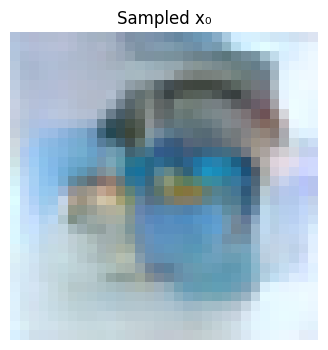

In [ ]:
model.eval()

with torch.no_grad():
    x0 = sample_ddpm(model, shape=(batch_size, 3, 32, 32),
                        betas=betas, alphas=alphas, alphas_cumprod=alphas_cumprod,
                        device=device)

visualize_sample(x0, idx=55)